In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import statsmodels.api as sm

from datetime import datetime
from IPython.display import display
from itertools import combinations
from matplotlib.ticker import MaxNLocator
from numpy.testing import assert_almost_equal
from sklearn.decomposition import PCA
from statsmodels.stats.proportion import proportions_ztest

# Custom output options.
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)
sns.set_style('darkgrid')
#sns.set_context('poster')
%matplotlib inline

# default folder to save LaTEX strings with save_df_latex().
DF_LATEX_FOLDER = 'am205_report_Yihang\\jupyter_tables\\'

CRYPTO_FILES = [('ripple_price', 'rip'), ('bitcoin_price', 'btc'),
                ('ethereum_price', 'eth'), ('litecoin_price', 'ltc'),
                ('monero_price', 'mon'), ('nem_price', 'nem'),
                ('dash_price', 'dash')]

BSK_FILES = [('AAPL', 'AAPL'), ('GLD', 'GLD'), ('HYG', 'HYG'), 
             ('X', 'X'), ('GE', 'GE'), ('M', 'M'), ('MOS', 'MOS')]

XLE_FILES = [('COP_data', 'COP'), ('CVX_data', 'CVX'),
                ('EOG_data', 'EOG'), ('OXY_data', 'OXY'),
                ('PSX_data', 'PSX'), ('SLB_data', 'SLB'),
                ('XOM_data', 'XOM')]

C:\Users\Nathaniel\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#####################################################################
# Utils used throughout the notebook to read/write data, perform  
# commonly used computations. 
#####################################################################

def load_returns_matrix (files, tdelta=pd.Timedelta(days=30), center=True, 
                         scale=True):
    """Returns cryptocurrency rolling returns for which a price level is 
    available for all the assets.
    
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_adj (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
    """
    dfs = []
    for file, name in files:
        path = 'cryptocurrencypricehistory//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    first_date = min(dfout.index)
    last_date = max(dfout.index)
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_adj = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_adj


def load_xle_returns (files, tdelta=pd.Timedelta(days=30), center=True, 
                      scale=True):
    """Returns top XLE components' rolling returns.
        
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_adj (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
    """
    dfs = []
    for file, name in files:
        path = 'XLE//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close']).iloc[::-1]
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_adj = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_adj

def load_other_returns (files, tdelta=pd.Timedelta(days=30), center=True, 
                        scale=True):
    """Creates rolling-return DataFrame for assets in files in other_assets 
    folder.
        
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_adj (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
    """
    dfs = []
    for file, name in files:
        path = 'other_assets//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['date', 'close'])
        df['date'] = pd.to_datetime(df['date'])
        df.columns = ['Date', 'Close']
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    first_date = min(dfout.index)
    last_date = max(dfout.index)
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_adj = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_adj

def create_proportion_of_variation_df (eigvals):
    total_var = sum(eigvals)
    cols = ['Component', 'Eigenvalue', 'Proportion', 'Cumulative']
    df = pd.DataFrame(columns=cols)
    cum = 0
    for i, e in enumerate(eigvals):
        cum += e
        row = {'Component':i + 1,
               'Eigenvalue':e,
               'Proportion':e/total_var,
               'Cumulative':cum/total_var}
        df = df.append(row, ignore_index=True)
    df['Component'] = df['Component'].astype(int)
    df.set_index('Component', drop=True, inplace=True)
    return df


def create_eigvec_df (eigvecs):
    """Create DataFrame of eigenvectors."""
    idx = [i + 1 for i in range(len(eigvecs))]
    df = pd.DataFrame(index=idx)
    for i, v in enumerate(eigvecs):
        df['V{}'.format(i + 1)] = v
    return df

def get_variation_loadings(df):
    """Computes proportion of variation explained (using eigenvalues) 
    and loadings of column variables on principal components.
    
    Args:
        df (DataFrame): Time series with columns representing assets.
    
    Returns:
        df_variation (DataFrame): Contains eigenvalues and proportion of 
            variation explained.
        df_loadings (DataFrame): Loadings for each principal component 
            on assets. Columns returned may be in different order than 
            they appear in df since they are sorted according to the 
            order of the eigenvalue magnitude.    
    """
    # Get SVD breakdown, cast into matrices.
    cov = np.cov(df.values.T)
    eig_vals, eig_vecs = np.linalg.eig(cov)
    # Create list of (eigenvalue, eigenvector, i) tuples
    # where i represents original ordering (for use in column names).
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i], i) 
                 for i in range(len(eig_vals))]
    
    # Sort from high to low, then extract now-sorted eigenvalues and 
    # eigenvectors.
    eig_pairs.sort(key = lambda x: x[0], reverse= True)
    eig_vecs = [epair[1] for epair in eig_pairs]
    eig_vals = np.array([epair[0] for epair in eig_pairs])
    newcol_indxs = [epair[2] for epair in eig_pairs]
    newcols = [df.columns[i] for i in newcol_indxs]
    
    # Create matrix with eigenvectors in columns.
    V = np.column_stack(eig_vecs)
    
    df_variation = create_proportion_of_variation_df(eig_vals)
    loadings = np.multiply(V, np.sqrt(eig_vals)).T
    newcols = [df.columns[e[2]] for e in eig_pairs]
    
    p = len(df.columns) # number of variables
    idx = pd.Series([i + 1 for i in range(p)], name='Component')
    df_loadings = pd.DataFrame(loadings, columns=newcols, index=idx)
    
    return df_variation, df_loadings 

def save_df_latex(df, filename, dec=None, folder=DF_LATEX_FOLDER):
    """Saves DataFrame to Latex in notebook-defined folder."""
    if filename[-4:] != '.txt': filename += '.txt'
    path = DF_LATEX_FOLDER + filename
    if dec is None: s = df.to_latex()
    else: s = df.round(dec).to_latex()
    
    with open(path, "w") as text_file:
        text_file.write(s)
        
def sxn_break(x):
    print(x)
    print('-'*30)

## Cryptocurrency returns analysis

In [3]:
# Init data and obtain covariance matrix.
cryp_unadj, cryp_std = load_returns_matrix(CRYPTO_FILES)

analysis_start_dt = min(cryp_std.index)
analysis_end_dt = max(cryp_std.index)

print('Number of returns in data: {}'.format(len(cryp_std.index)))
print('Analysis start date: {}'.format(analysis_start_dt))
print('Analysis end date: {}'.format(analysis_end_dt))

Number of returns in data: 794
Analysis start date: 2015-09-06 00:00:00
Analysis end date: 2017-11-07 00:00:00


### Basic features of unstandardized price return data

In [4]:
print('Price return statistics without centering/scaling:')
print('Mean returns:')
display(cryp_unadj.mean(axis=0))
print('S.D. of returns:')
display(cryp_unadj.std(axis=0))
print('Cumulative return:')
display((cryp_unadj + 1).prod(axis=0))
print('Correlation:')
cryp_unadj.corr()

Price return statistics without centering/scaling:
Mean returns:


rip     0.395
btc     0.150
eth     0.410
ltc     0.173
mon     0.364
nem     0.585
dash    0.277
dtype: float64

S.D. of returns:


rip     1.468
btc     0.232
eth     0.836
ltc     0.475
mon     0.873
nem     1.190
dash    0.620
dtype: float64

Cumulative return:


rip     1.841e+43
btc     8.094e+41
eth     2.544e+71
ltc     7.702e+36
mon     3.682e+66
nem     1.561e+98
dash    3.883e+60
dtype: float64

Correlation:


,rip,btc,eth,ltc,mon,nem,dash
rip,1.000,0.305,0.325,0.694,0.066,0.630,0.037
btc,0.305,1.000,0.164,0.322,0.102,0.349,0.031
eth,0.325,0.164,1.000,0.192,0.171,0.361,0.470
ltc,0.694,0.322,0.192,1.000,0.044,0.428,0.018
mon,0.066,0.102,0.171,0.044,1.000,0.114,0.128
nem,0.630,0.349,0.361,0.428,0.114,1.000,0.133
dash,0.037,0.031,0.470,0.018,0.128,0.133,1.000


### Proportion of Variation Explained

In [5]:
cryp_variation, cryp_loadings = get_variation_loadings(cryp_std)
display(cryp_variation.round(3))

,Eigenvalue,Proportion,Cumulative
Component,,,
1,2.657,0.379,0.379
2,1.376,0.196,0.575
3,0.941,0.134,0.710
4,0.769,0.110,0.819
5,0.564,0.080,0.900
6,0.464,0.066,0.966
7,0.239,0.034,1.000


### Loadings

In [6]:
display(cryp_loadings.round(3))

,rip,btc,ltc,mon,nem,dash,eth
Component,,,,,,,
1,0.844,0.544,0.583,0.742,0.224,0.793,0.284
2,0.278,0.176,-0.596,0.363,-0.383,0.074,-0.793
3,-0.102,0.296,-0.198,-0.063,0.853,-0.036,-0.266
4,-0.250,0.760,0.006,-0.198,-0.273,-0.039,0.114
5,-0.011,-0.071,0.171,-0.459,-0.042,0.481,-0.293
6,-0.009,-0.043,-0.485,-0.059,0.018,0.321,0.346
7,0.373,0.044,-0.058,-0.250,0.006,-0.171,0.051


# Are cryptocurrencies an asset class?

## Taking a look at energy (XLE) and a random basket

In [7]:
#####################################################################
# Load reference datasets and filter to be in same time frame as 
# cryptos. Compute their proportion-of-variations and loadings.
#####################################################################

# Load energy.
XLE_df, XLE_df_std = load_xle_returns(XLE_FILES)
XLE_df = XLE_df[XLE_df.index >= analysis_start_dt]
XLE_df = XLE_df[XLE_df.index <= analysis_end_dt]
XLE_df_std = XLE_df_std[XLE_df_std.index >= analysis_start_dt]
XLE_df_std = XLE_df_std[XLE_df_std.index <= analysis_end_dt]

xle_variation, xle_loadings = get_variation_loadings(XLE_df_std)

# Load basket.
bsk_df, bsk_df_std = load_other_returns(BSK_FILES)
bsk_df = bsk_df[bsk_df.index >= analysis_start_dt]
bsk_df = bsk_df[bsk_df.index <= analysis_end_dt]
bsk_df_std = bsk_df_std[bsk_df_std.index >= analysis_start_dt]
bsk_df_std = bsk_df_std[bsk_df_std.index <= analysis_end_dt]

bsk_variation, bsk_loadings = get_variation_loadings(bsk_df_std)

print('XLE returns in data: {}'.format(len(XLE_df_std.index)))
print('Basket returns in data: {}'.format(len(bsk_df_std.index)))

XLE returns in data: 284
Basket returns in data: 9


### Proportion of Variation Explained

In [8]:
print('XLE')
display(xle_variation.round(3))
print('\nBasket')
display(bsk_variation.round(3))

XLE


,Eigenvalue,Proportion,Cumulative
Component,,,
1,5.129,0.669,0.669
2,0.964,0.126,0.795
3,0.598,0.078,0.873
4,0.421,0.055,0.928
5,0.230,0.030,0.958
6,0.192,0.025,0.983
7,0.132,0.017,1.000



Basket


,Eigenvalue,Proportion,Cumulative
Component,,,
1,2.972,0.714,0.714
2,0.824,0.198,0.911
3,0.210,0.050,0.962
4,0.105,0.025,0.987
5,0.032,0.008,0.995
6,0.018,0.004,0.999
7,0.003,0.001,1.000


### Loadings

In [9]:
print('XLE')
display(xle_loadings.round(3))
print('\nBasket')
display(bsk_loadings.round(3))

save_df_latex(xle_loadings, 'XLE loadings', dec=3)
save_df_latex(bsk_loadings, 'Basket loadings', dec=3)

XLE


,COP,CVX,EOG,OXY,XOM,SLB,PSX
Component,,,,,,,
1,-0.996,-0.959,-0.886,-0.861,-0.541,-0.812,-0.860
2,-0.672,-0.035,-0.092,0.383,-0.269,0.226,0.483
3,0.146,0.353,-0.351,-0.163,-0.131,-0.366,0.390
4,0.226,-0.043,0.108,0.126,-0.577,0.000,-0.089
5,-0.013,-0.142,0.208,0.170,0.069,-0.355,0.081
6,0.143,-0.141,-0.282,0.255,0.075,0.015,-0.034
7,-0.100,0.234,-0.017,0.144,0.003,-0.076,-0.201



Basket


,AAPL,GLD,HYG,X,GE,M,MOS
Component,,,,,,,
1,0.825,0.809,-0.459,-0.450,-1.074,-0.135,0.227
2,0.057,-0.421,-0.185,0.572,-0.486,0.091,-0.193
3,0.017,-0.069,0.017,-0.193,-0.036,-0.107,-0.393
4,-0.207,0.208,-0.024,0.094,-0.050,-0.000,-0.088
5,0.086,0.055,0.122,0.072,0.017,0.005,-0.039
6,-0.046,-0.026,0.081,-0.024,-0.066,-0.049,0.037
7,-0.006,-0.002,0.013,-0.017,-0.013,0.052,-0.004


### Proportion z-test

In [10]:
def count_same_sign(df, column_pair, n_comp):
    """Computes number of times loadings are of the same sign for pair of 
    assets among n_comp components.
    
    Args:
        df (DataFrame): Contains loadings for each asset against component 
            number (index). Assumes that the loadings for the first 
            component are in the first row, the second component the second
            row, etc.
        column_pair (Sequence of length 2): Contains pair of column names 
            for assets whose loadings we want to compare.
        n_comp (int): Number of components to compare the two assets on.
    
    Returns:
        ss_count (int): Number of times loadings are of the same sign.
    """
    ss_count = 0
    x1, x2 = column_pair
    for i in range(n_comp):
        loadings = [df.iloc[i][x1], df.iloc[i][x2]]
        signs = [int(s) for s in np.sign(loadings)]
        if abs(sum(signs)) == 2:
            ss_count += 1
    return ss_count

In [11]:
# Perform proportion z-test using proportion of times the crypto pair 
# had the same loading signs.

def get_same_sign_count_df(df_loadings, ncomp):
    asset_pairs = list(combinations(df_loadings.columns, 2))
    data_rows = []
    for pair in asset_pairs:
        count = count_same_sign(df_loadings, pair, n_comp=ncomp)
        data_rows.append([pair[0], pair[1], count])
    cols = ['Asset 1', 'Asset 2', 'Same Sign Loading']
    df = pd.DataFrame(data_rows, columns=cols)
    return df

def perform_proportion_ztest(ss_df, ncomp, null_hypo_value = 0.5):
    """Performs proportion z-test on DF containing number of same-sign pairs."""    
    ss_counts = ss_df['Same Sign Loading'].tolist()
    total_same_sign = sum(ss_counts)
    total_obs = ncomp * len(ss_df.index)
    return proportions_ztest(total_same_sign, 
                             nobs=total_obs, 
                             value=null_hypo_value,
                             alternative='larger', 
                             prop_var=null_hypo_value)

In [12]:
# Prepare DataFrame storing number of times the loadings for a pair of 
# assets have the same signs for a certain number of PCs.

# Number of components to check loadings for.
ss_ncomp_cryp = 3
ss_ncomp_xle = 2
ss_ncomp_bsk = 1

cryp_ss_df = get_same_sign_count_df(cryp_loadings, ss_ncomp_cryp)
xle_ss_df = get_same_sign_count_df(xle_loadings, ss_ncomp_xle)
bsk_ss_df = get_same_sign_count_df(bsk_loadings, ss_ncomp_bsk)

# Conduct tests for each set of assets and store results in DF.
proptest_results = []

# Cryptos
zstat, pval = perform_proportion_ztest(cryp_ss_df, ss_ncomp_cryp)
prop_var = cryp_variation.at[ss_ncomp_cryp, 'Cumulative']
proptest_results.append([ss_ncomp_cryp, zstat, pval, prop_var])

# Energy
zstat, pval = perform_proportion_ztest(xle_ss_df, ss_ncomp_xle)
prop_var = xle_variation.at[ss_ncomp_xle, 'Cumulative']
proptest_results.append([ss_ncomp_xle, zstat, pval, prop_var])

# Basket
zstat, pval = perform_proportion_ztest(bsk_ss_df, ss_ncomp_bsk)
prop_var = bsk_variation.at[ss_ncomp_bsk, 'Cumulative']
proptest_results.append([ss_ncomp_bsk, zstat, pval, prop_var])

proptest_results = np.array(proptest_results).T
proptest_results = pd.DataFrame(
    proptest_results, columns=['Crypto', 'Energy', 'Basket'],
    index=['Components', '$z$', '$p$-value', '$\sigma^2$'])

display(proptest_results)
# save_df_latex(proptest_results, 'proportion test results')

,Crypto,Energy,Basket
Components,3.000,2.000,1.000
$z$,2.394,2.777,-0.655
$p$-value,0.008,0.003,0.744
$\sigma^2$,0.710,0.795,0.714


### Inter-temporal consistency of covariance matrix

In [13]:
# Split crypto DF into two time periods.

tmid = int(len(cryp_std.index)/2)
cryp_t1 = cryp_std.iloc[0:tmid]
cryp_t2 = cryp_std.iloc[tmid:]
print('Time frame 1: {}-{}'.format(min(cryp_t1.index), max(cryp_t1.index)))
print('Time frame 2: {}-{}'.format(min(cryp_t2.index), max(cryp_t2.index)))

Time frame 1: 2015-09-06 00:00:00-2016-10-06 00:00:00
Time frame 2: 2016-10-07 00:00:00-2017-11-07 00:00:00


In [14]:
# Prepare proportion of variation and loadings DF for both time periods.

variation_t1, loadings_t1 = get_variation_loadings(cryp_t1)
variation_t2, loadings_t2 = get_variation_loadings(cryp_t2)

In [15]:
print('Variation in 1st time period:')
display(variation_t1)
print('\nVariation in 2nd time period:')
display(variation_t2)

Variation in 1st time period:


,Eigenvalue,Proportion,Cumulative
Component,,,
1,1.654,0.383,0.383
2,1.070,0.248,0.631
3,0.783,0.181,0.813
4,0.596,0.138,0.951
5,0.156,0.036,0.987
6,0.033,0.008,0.995
7,0.022,0.005,1.000



Variation in 2nd time period:


,Eigenvalue,Proportion,Cumulative
Component,,,
1,4.417,0.485,0.485
2,2.263,0.248,0.734
3,1.163,0.128,0.861
4,0.593,0.065,0.926
5,0.279,0.031,0.957
6,0.222,0.024,0.981
7,0.169,0.019,1.000


In [16]:
print('Loadings in T1:')
display(loadings_t1.round(3))
print('\nLoadings in T2:')
display(loadings_t2.round(3))

Loadings in T1:


,rip,btc,eth,ltc,dash,nem,mon
Component,,,,,,,
1,-0.026,0.015,-0.181,-0.008,-1.270,-0.082,-0.017
2,-0.053,0.065,-0.930,0.027,0.161,-0.404,-0.090
3,-0.021,-0.478,0.258,-0.064,0.002,-0.690,0.085
4,-0.032,-0.591,-0.215,-0.236,0.001,0.365,0.103
5,-0.018,0.053,-0.029,0.056,-0.000,-0.005,0.386
6,0.067,0.051,0.002,-0.159,0.001,-0.019,0.019
7,0.137,-0.022,-0.010,0.050,-0.002,0.003,0.001



Loadings in T2:


,rip,btc,eth,ltc,dash,nem,mon
Component,,,,,,,
1,1.221,0.559,0.629,1.030,0.233,1.013,0.274
2,0.315,-0.059,-0.632,0.417,-0.231,0.008,-1.238
3,0.177,-0.947,-0.010,0.374,-0.151,-0.097,0.249
4,0.401,-0.177,0.077,-0.572,-0.130,0.204,-0.096
5,-0.051,0.041,-0.380,-0.009,-0.143,0.261,0.204
6,0.160,-0.016,-0.205,-0.044,0.368,-0.113,0.062
7,0.182,0.127,-0.054,0.016,-0.198,-0.256,0.108


#### Regression model from time period 1 to time period 2

In [53]:
dft1 = pd.DataFrame()
dft1['t1load'] = np.ravel(loadings_t1.iloc[0:3].values)
dft1['intercept'] = 1

Y = np.ravel(loadings_t2.iloc[0:3].values)

model = sm.OLS(Y, dft1).fit()

In [69]:
n_comp = 3 # number of components to analyze
n_days = 30 # number of days to create chunks
periods = int(len(cryp_std.index) / n_days)

time_results = []

for i in range(periods-1):
    idx0, idx1, idx2 = i * n_days, (i+1)*n_days, (i + 2)*n_days
    df_x = pd.DataFrame()
    df_x['t1_load'] = np.ravel(cryp_std.iloc[idx0:idx1-1].values)
    df_x['intercept'] = 1
    Y = np.ravel(cryp_std.iloc[idx1:idx2-1].values)
    model = sm.OLS(Y, df_x).fit()
    results = [cryp_std.iloc[idx0].name, model.rsquared, model.f_pvalue]
    time_results.append(results)

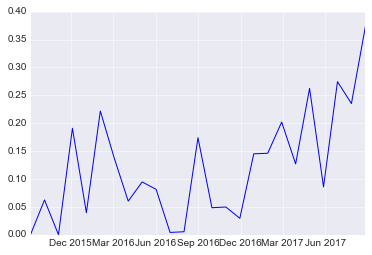

In [71]:
x = [t[0] for t in time_results]
y = [t[1] for t in time_results]
plt.xlabel('Start time')
plt.plot(x, y);

## Yihang's code

In [18]:
small_df_std = cryp_std
small_df_std.head()

,rip,btc,eth,ltc,mon,nem,dash
Date,,,,,,,
2015-09-06,-0.291,-1.261,-1.125,-0.946,-0.783,-0.776,-0.828
2015-09-07,-0.314,-0.998,0.299,-0.803,-0.717,-0.739,-0.814
2015-09-08,-0.345,-0.998,0.427,-0.825,-0.684,-0.693,-0.852
2015-09-09,-0.353,-1.077,0.357,-0.915,-0.680,-0.772,-0.782
2015-09-10,-0.343,-1.157,-0.378,-0.979,-0.619,-0.766,-0.845


In [19]:
cov = np.cov(small_df_std.values.T)     # covariance matrix
corr = np.corrcoef(cryp_unadj.values.T)
eig_vals, eig_vecs = np.linalg.eig(cov)
eig_vals

array([ 2.657,  1.376,  0.239,  0.941,  0.769,  0.564,  0.464])

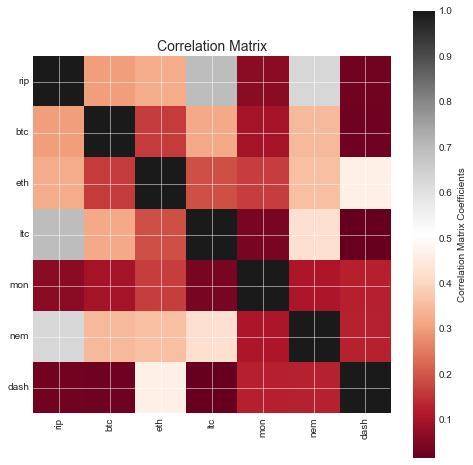

In [20]:
tickers = list(small_df_std.columns)

# Graph - Correlation matrix
plt.figure(figsize=(8,8))
plt.imshow(corr, cmap="RdGy", interpolation="nearest")
cb = plt.colorbar()
cb.set_label("Correlation Matrix Coefficients")
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(np.arange(len(tickers)), tickers, rotation=90)
plt.yticks(np.arange(len(tickers)), tickers);

the correlation matrix typically used instead of the covariance matrix. However, the eigendecomposition of the covariance matrix (if the input data was standardized) yields the same results as a eigendecomposition on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix.

In [21]:
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] 
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

cum_var_exp

array([  37.915,   57.55 ,   70.972,   81.939,   89.979,   96.592,  100.   ])

In [22]:
print(57.55 - 37.915)
print(70.972 - 57.55)
print(81.939 - 70.972)
print(89.979 - 81.939)
print(96.592 - 89.979)
print(100 - 96.592)

19.634999999999998
13.421999999999997
10.966999999999999
8.040000000000006
6.6129999999999995
3.4080000000000013


In [23]:
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs

[(2.6573777970786585,
  array([ 0.517,  0.334,  0.358,  0.455,  0.137,  0.487,  0.174])),
 (1.3761939225744024,
  array([ 0.237,  0.15 , -0.508,  0.309, -0.327,  0.063, -0.676])),
 (0.23884834723260553,
  array([ 0.764,  0.091, -0.118, -0.511,  0.012, -0.351,  0.103])),
 (0.9407062524264399,
  array([-0.105,  0.305, -0.204, -0.065,  0.88 , -0.037, -0.274])),
 (0.76868538699591216,
  array([-0.286,  0.867,  0.007, -0.226, -0.311, -0.044,  0.13 ])),
 (0.56351198020471516,
  array([-0.015, -0.095,  0.228, -0.611, -0.056,  0.64 , -0.39 ])),
 (0.46350355182270114,
  array([-0.013, -0.064, -0.712, -0.087,  0.027,  0.472,  0.508]))]

### Sorting Eigenpairs

In [24]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_vals_list = []
print('Eigenvalues in descending order:')
for i in eig_pairs:
    eig_vals_list.append(i[0])
    print(i[0])

Eigenvalues in descending order:
2.65737779708
1.37619392257
0.940706252426
0.768685386996
0.563511980205
0.463503551823
0.238848347233


In [25]:
matrix_Q = np.hstack((eig_pairs[0][1].reshape(7,1),
                      eig_pairs[1][1].reshape(7,1),
                      eig_pairs[2][1].reshape(7,1),
                      eig_pairs[3][1].reshape(7,1),
                      eig_pairs[4][1].reshape(7,1),
                      eig_pairs[5][1].reshape(7,1),
                      eig_pairs[6][1].reshape(7,1)))
#with desending order of eigen value 
matrix_Q

array([[ 0.517,  0.237, -0.105, -0.286, -0.015, -0.013,  0.764],
       [ 0.334,  0.15 ,  0.305,  0.867, -0.095, -0.064,  0.091],
       [ 0.358, -0.508, -0.204,  0.007,  0.228, -0.712, -0.118],
       [ 0.455,  0.309, -0.065, -0.226, -0.611, -0.087, -0.511],
       [ 0.137, -0.327,  0.88 , -0.311, -0.056,  0.027,  0.012],
       [ 0.487,  0.063, -0.037, -0.044,  0.64 ,  0.472, -0.351],
       [ 0.174, -0.676, -0.274,  0.13 , -0.39 ,  0.508,  0.103]])

## Loadings

Compute loadings A. May skip if you don't need to interpret PCs anyhow.
Loadings are eigenvectors normalized to respective eigenvalues: A value = V value * sqrt(L value)
Loadings are the covariances between variables and components.

Loadings=Orthonormal Eigenvectors⋅ Square root of (Absolute Eigen values)

In [26]:
eig_vals_sqrt = np.array([np.sqrt(eig_val) for eig_val in eig_vals_list])
eig_vals_sqrt

array([ 1.63 ,  1.173,  0.97 ,  0.877,  0.751,  0.681,  0.489])

In [27]:
ordered_col = (['rip','btc','ltc','mon','nem','dash','eth'])
loadings = pd.DataFrame(np.multiply(matrix_Q, eig_vals_sqrt)).T
loadings.columns = ordered_col
display(loadings)
display(matrix_Q)

,rip,btc,ltc,mon,nem,dash,eth
0,0.844,0.544,0.583,0.742,0.224,0.793,0.284
1,0.278,0.176,-0.596,0.363,-0.383,0.074,-0.793
2,-0.102,0.296,-0.198,-0.063,0.853,-0.036,-0.266
3,-0.250,0.760,0.006,-0.198,-0.273,-0.039,0.114
4,-0.011,-0.071,0.171,-0.459,-0.042,0.481,-0.293
5,-0.009,-0.043,-0.485,-0.059,0.018,0.321,0.346
6,0.373,0.044,-0.058,-0.250,0.006,-0.171,0.051


array([[ 0.517,  0.237, -0.105, -0.286, -0.015, -0.013,  0.764],
       [ 0.334,  0.15 ,  0.305,  0.867, -0.095, -0.064,  0.091],
       [ 0.358, -0.508, -0.204,  0.007,  0.228, -0.712, -0.118],
       [ 0.455,  0.309, -0.065, -0.226, -0.611, -0.087, -0.511],
       [ 0.137, -0.327,  0.88 , -0.311, -0.056,  0.027,  0.012],
       [ 0.487,  0.063, -0.037, -0.044,  0.64 ,  0.472, -0.351],
       [ 0.174, -0.676, -0.274,  0.13 , -0.39 ,  0.508,  0.103]])

In [28]:
sqr_loadings = loadings.applymap(np.square)
sqr_loadings

,rip,btc,ltc,mon,nem,dash,eth
0,7.116e-01,0.296,3.399e-01,0.550,5.002e-02,0.629,0.081
1,7.709e-02,0.031,3.546e-01,0.132,1.469e-01,0.006,0.629
2,1.034e-02,0.087,3.919e-02,0.004,7.279e-01,0.001,0.071
3,6.275e-02,0.578,3.784e-05,0.039,7.427e-02,0.001,0.013
4,1.239e-04,0.005,2.925e-02,0.211,1.757e-03,0.231,0.086
5,7.429e-05,0.002,2.350e-01,0.003,3.313e-04,0.103,0.119
6,1.393e-01,0.002,3.314e-03,0.062,3.500e-05,0.029,0.003


In [29]:
#make sure each row of square loadings table = eigenvalue
7.107e-01+0.296+3.395e-01+0.549+4.995e-02+0.628+0.081

2.65415

In [30]:
7.699e-02+0.031+3.542e-01+0.132+1.467e-01+0.006+0.628

1.3748900000000002

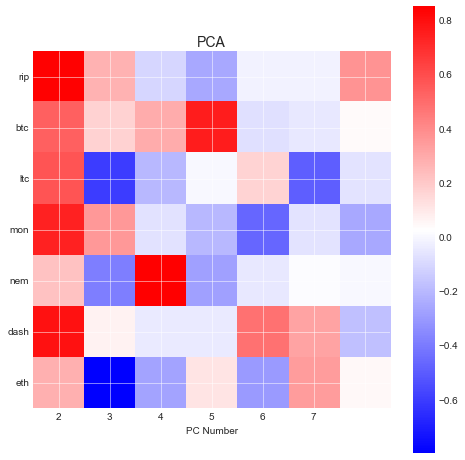

In [31]:
LL = np.multiply(matrix_Q,eig_vals_sqrt)
tickers = ordered_col
ax = plt.figure(figsize=(8,8)).gca()
plt.imshow(LL, cmap="bwr", interpolation="nearest")
cb = plt.colorbar()
plt.yticks(np.arange(len(tickers)), tickers)
plt.xticks(np.arange(len(tickers)), [1,2,3,4,5,6,7])
plt.xlabel("PC Number")
plt.title("PCA", fontsize=14)
# force x-tickers to be displayed as integers (not floats)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

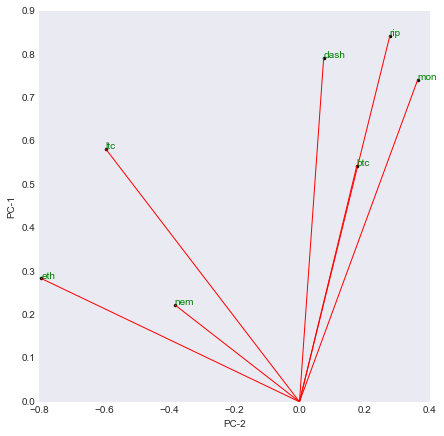

In [32]:
k1 = 1  # the last PC column in 'v' PCA matrix
k2 = 0  # the second last PC column
 
# begin constructing bi-plot for PC(k1) and PC(k2)
# loadings
plt.figure(figsize=(7,7))
plt.grid()
 
# compute the distance from (0,0) point
dist = []
for i in range(LL.shape[0]):
    x = LL[i,k1]
    y = LL[i,k2]
    plt.plot(x, y, '.k')
    plt.plot([0,x], [0,y], '-', color="r")
    d = np.sqrt(x**2 + y**2)
    dist.append(d)
    plt.text(x, y, tickers[i], color='g')
plt.xlabel("PC-" + str(k1+1))
plt.ylabel("PC-" + str(k2+1));

## Looking at energy (XLE)

In [33]:
cov = np.cov(XLE_df_std.values.T)     # covariance matrix
corr = np.corrcoef(XLE_df.values.T)   # correlation matrix
eig_vals, eig_vecs = np.linalg.eig(cov)

In [34]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_vals_list = []
print('Eigenvalues in descending order:')
for i in eig_pairs:
    eig_vals_list.append(i[0])
    print(i[0])

Eigenvalues in descending order:
5.12897457497
0.964145398491
0.598402597906
0.421225132414
0.229609637483
0.192159626877
0.132215421912


In [35]:
matrix_Q = np.hstack((eig_pairs[0][1].reshape(7,1),
                      eig_pairs[1][1].reshape(7,1),
                      eig_pairs[2][1].reshape(7,1),
                      eig_pairs[3][1].reshape(7,1),
                      eig_pairs[4][1].reshape(7,1),
                      eig_pairs[5][1].reshape(7,1),
                      eig_pairs[6][1].reshape(7,1)))
matrix_Q

array([[-0.44 , -0.684,  0.189,  0.349, -0.027,  0.325, -0.274],
       [-0.423, -0.036,  0.456, -0.066, -0.295, -0.323,  0.645],
       [-0.391, -0.093, -0.454,  0.167,  0.433, -0.644, -0.048],
       [-0.38 ,  0.39 , -0.211,  0.194,  0.355,  0.583,  0.395],
       [-0.239, -0.274, -0.169, -0.889,  0.144,  0.17 ,  0.007],
       [-0.358,  0.231, -0.473,  0.   , -0.741,  0.035, -0.21 ],
       [-0.38 ,  0.492,  0.504, -0.137,  0.169, -0.077, -0.554]])

In [36]:
eig_vals_sqrt = np.array([np.sqrt(eig_val) for eig_val in eig_vals_list])

ordered_col = (["COP","SLB","XOM","PSX","OXY","EOG","CVX"])
loadings = pd.DataFrame(np.multiply(matrix_Q,eig_vals_sqrt)).T
loadings.columns = ordered_col
display(loadings.round(3))

,COP,SLB,XOM,PSX,OXY,EOG,CVX
0,-0.996,-0.959,-0.886,-0.861,-0.541,-0.812,-0.860
1,-0.672,-0.035,-0.092,0.383,-0.269,0.226,0.483
2,0.146,0.353,-0.351,-0.163,-0.131,-0.366,0.390
3,0.226,-0.043,0.108,0.126,-0.577,0.000,-0.089
4,-0.013,-0.142,0.208,0.170,0.069,-0.355,0.081
5,0.143,-0.141,-0.282,0.255,0.075,0.015,-0.034
6,-0.100,0.234,-0.017,0.144,0.003,-0.076,-0.201


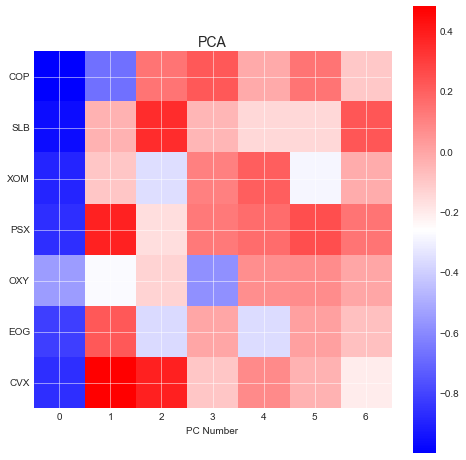

In [37]:
sqr_loadings = loadings.applymap(np.square)

LL = np.multiply(matrix_Q,eig_vals_sqrt)
tickers = ordered_col
ax = plt.figure(figsize=(8,8)).gca()
plt.imshow(LL, cmap="bwr", interpolation="nearest")
cb = plt.colorbar()
plt.yticks(np.arange(len(tickers)), tickers)
plt.xlabel("PC Number")
plt.title("PCA", fontsize=14)
# force x-tickers to be displayed as integers (not floats)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

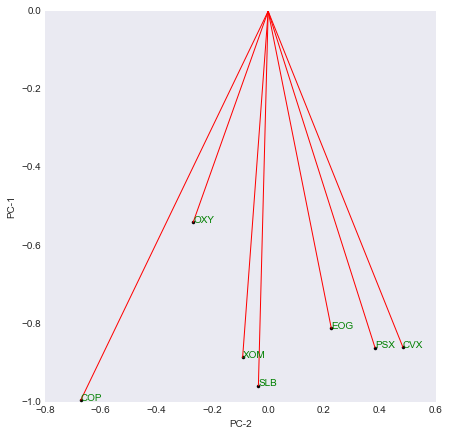

In [38]:
k1 = 1  # the last PC column in 'v' PCA matrix
k2 = 0  # the second last PC column
 
# begin constructing bi-plot for PC(k1) and PC(k2)
# loadings
plt.figure(figsize=(7,7))
plt.grid()
 
# compute the distance from (0,0) point
dist = []
for i in range(LL.shape[0]):
    x = LL[i,k1]
    y = LL[i,k2]
    plt.plot(x, y, '.k')
    plt.plot([0,x], [0,y], '-', color="r")
    d = np.sqrt(x**2 + y**2)
    dist.append(d)
    plt.text(x, y, tickers[i], color='g')
plt.xlabel("PC-" + str(k1+1))
plt.ylabel("PC-" + str(k2+1));